# Notebook Overview

This notebook includes a general overview of the dataset by (1) preparing your workspace to use the dataset in the COCO format, (2) visualizing a few images from one of the datasets for information purposes, and (3) conducting an analysis on modifications made to the Faster R-CNN model.  The dataset used is the SARscope dataset found at the below link.  The objective of this project is to determine whether proposed image processing methods would increase the performance of different models on Synthetic Aperture Radar data of maritime vessels.

Dataset: https://www.kaggle.com/datasets/kailaspsudheer/sarscope-unveiling-the-maritime-landscape

## Section 1 - Workspace Preparation

To ensure that the user can run this notebook without issue, please do the following:

1. Ensure your Python installtion is 3.8.10 or higher.
2. You are using the pip3 package manager.
3. Run the below installation steps. These are all the packages used in this notebook.

In [1]:
# %pip3 install torch
# %pip3 install torchvision
# %pip3 install torchmetrics
# %pip3 install kagglehub
# %pip3 install json
# %pip3 install matplotlib
# %pip3 install cv2
# %pip install pycocotools
# %pip install utils

In [2]:
# Utility Imports
import os, sys
import pathlib
import matplotlib.pyplot as plt

project_path = pathlib.Path.cwd().parent.resolve().parent.resolve()
print(f"Project path: {project_path}")

sys.path.append(os.path.join(project_path, "src", "frcnn"))
sys.path.append(os.path.join(project_path, "src", "utils"))

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
# from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import gc
import torch
import sys
import matplotlib.pyplot as plt
from torchmetrics.functional.detection import intersection_over_union
from torchmetrics.detection import MeanAveragePrecision


class ModelWorkerFRCNN:
    """
    Training, validation, & testing functionality for use FRCNN in Pytorch.

    Args:
        - train_data: Dataloader for the training data images and labels.
        - validation_data: Dataloader for the validation data images and labels.
        - optimizer: Optimizer for the model.
        - frcnn: FRCNN specific model to train.
        - quiet: Whether to print training, validation, and testing messages.
        - debug: Prints additional messages for debugging throughout code.


    NOTE: FRCNN returns a dictionary of different loss values, each described below:
        1. loss_objectness: Binary cross entropy function to measure whether a region proposal is "background" or an object
        2. loss_rpn_box_reg: L1 Loss function to measure the loss in the region proposal's bounding box coordinates.
        3. loss_classifier: Cross Entropy loss function to measure the the classification loss of an object within a region proposal.
        4. loss_box_reg: L1 Loss function to measure the loss in the bounding box coordinates of the object in a region proposal.
    """
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 frcnn: torch.nn.Module,
                 quiet: bool = True,
                 debug: bool = False):

        self._optimizer = optimizer
        self._frcnn = frcnn
        self._quiet = quiet
        self._debug = debug

        if torch.cuda.is_available():
            self._device = 'cuda'
        else:
            self._device = 'cpu'

        if self._debug:
            print(f"Pytorch found device: {self._device}")

        # Send the components to whatever device is currently available.
        self._frcnn.to(self._device)

        # Store general metrics
        self._train_metrics = {'LOSS': None, 'num_epochs': None}
        self._validation_metrics = {'LOSS': None, 'num_epochs': None}

    def train(self, train_dataloader: torch.utils.data.DataLoader, num_epochs: int, indices_to_skip: list = []):
        """
        Run Training step.

        Args:
            - train_dataloader: The training data loader object.
            - num_epochs: Number of training iterations to run.
            - skip_index: Data instances to skip during training
                - Some data instances are missing their annotations in the Kaggle dataset.  We will skip these and notify the
                  creator.
                - Known Indices: [3736]
        """
        self._train_metrics['num_epochs'] = num_epochs
        self._frcnn.train()
        training_epoch_losses = {'epoch_loss': [], 'loss_objectness': [], 'loss_rpn_box_reg': [], 'loss_box_reg': [], 'loss_classifier': []}

        for epoch in range(num_epochs):
            train_batch_losses = {'epoch_loss': 0, 'loss_objectness': 0, 'loss_rpn_box_reg': 0, 'loss_box_reg': 0, 'loss_classifier': 0}
            for i, (images, annotations) in enumerate(train_dataloader):
                if i in indices_to_skip:
                    break
                    continue
                try:
                    # Move all images and annotation values to the correct device
                    images = tuple([image.to(self._device) for image in images])
                    annotations = [{key: value.to(self._device) for key, value in target.items()} for target in annotations]

                    # Do forward propagation and get the loss values for the image
                    # NOTE: train_loss is a dictionary containing different loss values for different things.
                    # Summing them produces a general loss value for this image, but we can extract different
                    # metrics using each loss value.  See class description and Pytorch documentation for more
                    # information.
                    train_loss = self._frcnn(images, annotations)
                    if isinstance(train_loss, tuple):
                        train_loss = train_loss[0]

                    train_loss_dict = train_loss

                    # Calculate total batch loss across all categories for backpropagation
                    train_loss = [loss for loss in train_loss.values()]
                    train_loss = sum(train_loss)

                    # Convert the losses to regular python values for metric tracking
                    train_loss_dict = {key: value.cpu().detach().numpy().tolist() for key, value in train_loss_dict.items()}

                    train_batch_losses['epoch_loss'] += float(train_loss.cpu().detach())
                    train_batch_losses['loss_objectness'] += train_loss_dict['loss_objectness']
                    train_batch_losses['loss_rpn_box_reg'] += train_loss_dict['loss_rpn_box_reg']
                    train_batch_losses['loss_box_reg'] += train_loss_dict['loss_box_reg']
                    train_batch_losses['loss_classifier'] += train_loss_dict['loss_classifier']

                    # Backpropagation
                    self._optimizer.zero_grad()
                    train_loss.backward()
                    self._optimizer.step()

                    if not self._quiet or self._debug:
                        print(f"Batch: {i}/{len(train_dataloader)} | Batch Loss: {train_loss}\r", end="")

                except Exception as e:
                    print(e)
                    print(f"Failed on Batch {i}")
                    print(f"Image: {images}")
                    print(f"Annotations: {annotations}")
                    sys.exit(-1)

            training_epoch_losses['epoch_loss'].append(train_batch_losses['epoch_loss'])
            training_epoch_losses['loss_objectness'].append(float(train_batch_losses['loss_objectness']))
            training_epoch_losses['loss_rpn_box_reg'].append(float(train_batch_losses['loss_rpn_box_reg']))
            training_epoch_losses['loss_box_reg'].append(float(train_batch_losses['loss_box_reg']))
            training_epoch_losses['loss_classifier'].append(float(train_batch_losses['loss_classifier']))

            if not self._quiet:
                print(f"\n\n############# Epoch: {epoch} Complete #############")
                print(f"Total Epoch Combined Loss: {training_epoch_losses['epoch_loss'][epoch]}")
                print(f"Loss Objectness: {training_epoch_losses['loss_objectness'][epoch]}")
                print(f"RPN Region Proposal Losses: {training_epoch_losses['loss_rpn_box_reg'][epoch]}")
                print(f"Classifier Loss: {training_epoch_losses['loss_classifier'][epoch]}")
                print(f"Bounding Box Region Loss: {training_epoch_losses['loss_box_reg'][epoch]}")
            print("\n")

            self._train_metrics['loss'] = training_epoch_losses

            # Free all memory from the current batch
            images = None
            annotations = None
            train_loss = None
            train_epoch_loss = None
            del images
            del annotations
            del train_loss
            del train_epoch_loss
            gc.collect()
            torch.cuda.empty_cache()

        self._train_metrics['LOSS'] = training_epoch_losses

        # Clean up memory from training
        training_epoch_losses = None
        self._optimizer = None
        del training_epoch_losses
        # del self._optimizer
        gc.collect()
        torch.cuda.empty_cache()

    def validation(self, validation_dataloader: torch.utils.data.DataLoader, num_epochs: int, indices_to_skip: list = []):
        """
        Run Validation step.

        Args:
            - validation_dataloader: Validation data place within Pytorch dataloader object
            - num_epochs: Number of epochs to run validation.
        """
        self._validation_metrics['num_epochs'] = num_epochs
        self._frcnn.train()
        validation_epoch_losses = {'epoch_loss': [], 'loss_objectness': [], 'loss_rpn_box_reg': [], 'loss_box_reg': [], 'loss_classifier': []}
        with torch.no_grad():
            for epoch in range(num_epochs):
                validation_batch_losses = {'epoch_loss': 0, 'loss_objectness': 0, 'loss_rpn_box_reg': 0, 'loss_box_reg': 0, 'loss_classifier': 0}
                # Run validation batch
                for i, (images, annotations) in enumerate(validation_dataloader):
                    if i in indices_to_skip:
                        break
                        continue
                    # Move all images and annotation values to the correct device
                    images = tuple([image.to(self._device) for image in images])
                    annotations = [{key: value.to(self._device) for key, value in target.items()} for target in annotations]

                    # Do forward propagation and get the loss values for the image
                    # NOTE: validation_loss is a dictionary with different loss values. See class description for more info.
                    validation_loss = self._frcnn(images, annotations)
                    if isinstance(validation_loss, tuple):
                        validation_loss = validation_loss[0]

                    validation_loss_dict = validation_loss

                    validation_loss = [loss for loss in validation_loss.values()]
                    validation_loss = sum(validation_loss)
                    validation_loss_dict = {key: value.cpu().detach().numpy().tolist() for key, value in validation_loss_dict.items()}
                    validation_batch_losses['epoch_loss'] += validation_loss.cpu().detach()
                    validation_batch_losses['loss_objectness'] += validation_loss_dict['loss_objectness']
                    validation_batch_losses['loss_rpn_box_reg'] += validation_loss_dict['loss_rpn_box_reg']
                    validation_batch_losses['loss_box_reg'] += validation_loss_dict['loss_box_reg']
                    validation_batch_losses['loss_classifier'] += validation_loss_dict['loss_classifier']

                    if not self._quiet or self._debug:
                        print(f"Batch: {i}/{len(validation_dataloader)} | Batch Loss: {validation_loss}\r", end="")

                    # Clean up from current batch
                    validation_loss = None
                    images = None
                    annotations = None
                    del validation_loss
                    del images
                    del annotations
                    gc.collect()
                    torch.cuda.empty_cache()

                validation_epoch_losses['epoch_loss'].append(validation_batch_losses['epoch_loss'])
                validation_epoch_losses['loss_objectness'].append(float(validation_batch_losses['loss_objectness']))
                validation_epoch_losses['loss_rpn_box_reg'].append(float(validation_batch_losses['loss_rpn_box_reg']))
                validation_epoch_losses['loss_box_reg'].append(float(validation_batch_losses['loss_box_reg']))
                validation_epoch_losses['loss_classifier'].append(float(validation_batch_losses['loss_classifier']))

                if not self._quiet:
                    print(f"\n\n############# Epoch: {epoch} Complete #############")
                    print(f"\tTotal Epoch Loss: {validation_epoch_losses['epoch_loss'][epoch]}")
                    print(f"\tLoss Objectness: {validation_epoch_losses['loss_objectness']}")
                    print(f"\tRPN Region Proposal Losses: {validation_epoch_losses['loss_rpn_box_reg'][epoch]}")
                    print(f"\tClassifier Loss: {validation_epoch_losses['loss_classifier'][epoch]}")
                    print(f"\tBounding Box Region Loss: {validation_epoch_losses['loss_box_reg'][epoch]}")

            self._validation_metrics['LOSS'] = validation_epoch_losses

            # Clean up final validation variables for memory conservation
            del validation_batch_losses
            gc.collect()
            torch.cuda.empty_cache()

    def model_test(self, test_data: torch.utils.data.DataLoader, threshold: float = 0.8):
        """
        Run Testing on the given model for this worker.

        Args:
            - test_data: Loader object for all testing data.
            - threshold: Minimum IOU score to consider in our metric calculations.
        """
        performance = {"Image": [], "Ground Truth": [], "Prediction": []}

        # maP = MeanAveragePrecision()
        # Set the model to evaluation mode
        self._frcnn.eval()
        with torch.no_grad():
            for test_batch, (images, annotations) in enumerate(test_data):
                images = tuple([image.to(self._device) for image in images])
                annotations = [{key: value.to(self._device) for key, value in target.items()} for target in annotations]

                test_prediction = self._frcnn(images, annotations) # Make a prediction on the current image.
                print(test_prediction[0])
                # maP.update(test_prediction, annotations)
                test_boxes = test_prediction[0]['boxes'].cpu().detach()

                ground_truth = []
                # Find the Intersection over Union for each bounding box compared to the ground truth annotation
                for gt in annotations[0]['boxes']:
                    ground_truth.append(torch.unsqueeze(gt.cpu().detach(), 0)[0])

                ground_truth = torch.stack(ground_truth)

                performance["Ground Truth"].append(ground_truth)
                performance["Prediction"].append(test_boxes)
                performance["Image"].append([image.cpu().detach() for image in images])

                if not self._quiet:
                    print(f"Test Batch: {test_batch}\r", end="")

        # return performance, maP
        return performance

    def plot_losses(self, plot_train: bool = True):
        fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 5))
        if plot_train:
            for i, (key, value) in enumerate(self._train_metrics['LOSS'].items()):
                ax[i].plot(range(0, self._train_metrics['num_epochs']), value)
                ax[i].set_title(f"Training Epoch {key}")
                ax[i].set_xlabel("Epochs")
                ax[i].set_ylabel(key)
        else:
            for i, (key, value) in enumerate(self._validation_metrics['LOSS'].items()):
                ax[i].plot(range(0, self._validation_metrics['num_epochs']), value)
                ax[i].set_title(f"Validation Epoch {key}")
                ax[i].set_xlabel("Epochs")
                ax[i].set_ylabel(key)

    def get_test_metrics(self, performance: dict, threshold: float):
        """
        Calculates the Intersection over Union, true positives, false positives, and false negatives.
        Then uses those to find the Precision and Recall for each ground truth element.

        According to this link: https://www.comet.com/site/blog/compare-object-detection-models-from-torchvision/,
            - True Positives are predicted bounding boxes whose IOU is greater than the threshold.
            - False Positives are predicted bounding boxes whose IOU is less than the threshold.
            - False Negatives are ground truth bounding boxes with no predictions made on them.

        Args:
            - performance: Dictionary containing the test result bounding boxes.
            - threshold: The Intersection over Union threshold.

        Returns:
            - performance: Updated dictionary containing the IOU, TP, FP, and FN values.
        """

        performance['True Positives'] = 0
        performance['False Positives'] = 0
        performance['False Negatives'] = 0
        performance['Precisions'] = []
        performance['Recalls'] = []
        performance['Best IOU'] = []
        for i, truth_boxes in enumerate(performance['Ground Truth']):
            for box in truth_boxes:
                if len(performance['Prediction'][i]) == 0:
                    performance['False Negatives'] += 1
                else:
                    best_iou = torch.max(intersection_over_union(performance['Prediction'][i], box.unsqueeze(0)))
                    if best_iou >= threshold:
                        performance['True Positives'] += 1
                    elif best_iou < threshold:
                        performance['False Positives'] += 1

                    performance['Best IOU'].append(best_iou)

                tp, fp, fn = performance['True Positives'], performance['False Positives'], performance['False Negatives']

                if tp > 0 or fp > 0:
                    precision = tp / (tp + fp)
                else:
                    precision = 0

                if tp > 0 or fn > 0:
                    recall = tp / (tp + fn)
                else:
                    recall = 0

                performance['Precisions'].append(precision)
                performance['Recalls'].append(recall)

        return performance

    def plot_PR_curve(self, performance: dict):
        """
        Plots the Precision-Recall curve.  performance dictionary must have True Positives, False Positives,
        and False Negatives keys from the get_test_metrics() method.

        Args:
            - performance: Dictionary containing most up-to-date metrics.
        """
        plt.plot(performance['Recalls'], performance['Precisions'])
        plt.xlabel("Recall")
        plt.ylabel("Precision")

## Section 2 - Dataset Loading

### Section 2.1: Note on Kagglehub

Kagglehub does not natively support downloading to specific directories on the user's file system.  It instead downloads it to a cache folder, which may vary between users.  Thus, the below script moves all downloads will move the dataset folder to the included */data* folder in this repo.

If you have an error, this is likely due to the `shutil.move()` command failing because it sees the dataset still cached.  To counteract this, `cd` into the cache directory that is printed in the output and delete the entire data folder.  Then run this block again.  See Section 2.2 and the below code block comments for additional information.

### Section 2.2: Deleting the Cache

To re-download the dataset, you need to remove both the formatted folder in this repo's data directory (the *kaggle* folder) and the *kailaspsudheer* folder in the cache.

I recommend you run the *WorkspaceManager* setup block below with *clear_cache* off first, then manually delete it if you need to.  After you know where your cache is and confirm it's deleting the right directory, you can turn it on.

In [4]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## Section 3 - Data Visualization

Below, we visualize a few randomly selected images throughout the validation dataset as examples of the different types of images the models will encounter and to ensure the annotations are working as expected.  All targets have the same category Id and category name: (1, "ship").

In [5]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


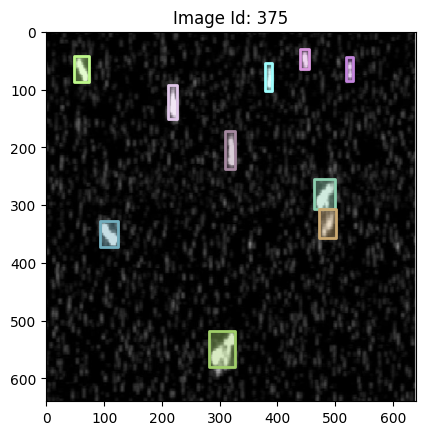

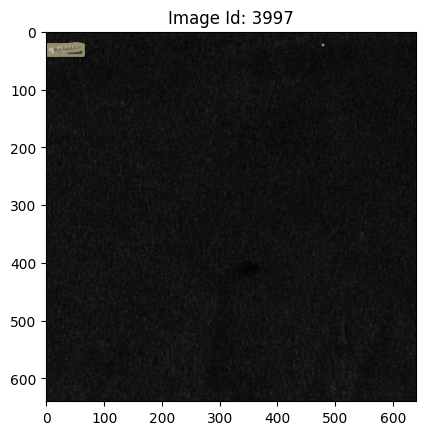

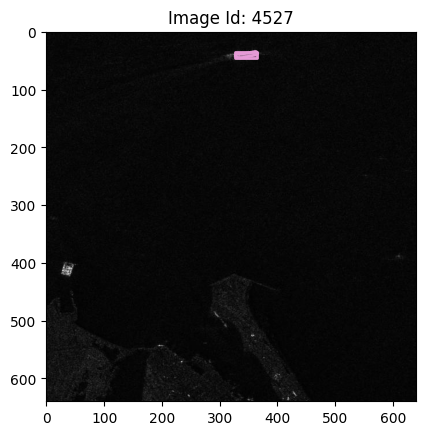

In [6]:
# Display 3 randomly selected images throughout the validation dataset with their annotations.
for i in range(3):
    train_data._random_image()
    plt.show()

## Section 4 - Faster R-CNN

This section begins the analysis of different layer additions and modifications to the Faster R-CNN model.  Each section contains the following sub-sections for reference:

1. Data Preparation
2. Model Construction
3. Training
4. Testing & Analysis

### Section 4.1 - Baseline FRCNN

This section is to establish the baseline performance of an unmodified FRCNN model on our dataset.

#### Section 4.1.1 - Data Preparation

In [7]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=train_data._packager, num_workers=20)

In [8]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True, collate_fn=validation_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#### Section 4.1.2 - Model Setup

In [9]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=1e-6)
sgd = torch.optim.SGD(frcnn.parameters(), lr=1e-5)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Section 4.1.3 - Baseline Training & Validation

When running training, be advised that you may need to close other programs, completely kill your Jupyter Kernel, or restart VSCode.  FRCNN and Pytorch consume significant amounts of memory per run and remain allocated in the background on your GPU.  After enough times running train/validation cells, the program will fail saying CUDA is out of memory.  This is when you must either manually kill background programs from the terminal or restart VSCode.  Below are the instructions to determine which programs to kill.

**NOTE**: These instructions were written for Ubuntu Linux 20.04.  Your steps may differ slightly.

1. Open a terminal window
2. Assuming you have CUDA set up, enter the "*nvidia-smi*" command.  This will display all processes currently using your GPU.
3. Run *sudo fuser -v /dev/nvidia\**.  This will display another list of process also using your GPU, including the owner of said process.
    - This step is to differentiate between your processes and system processes.  
    - **DO NOT EVER KILL A SYSTEM PROCESS USING THESE STEPS. IF IT IS CAUSING PROBLEMS, RESTART YOUR COMPUTER AND THIS CAN SAFELY REFRESH ALL PROCESSES USING YOUR GPU.**
4. Identify all processes owned by you and get their PIDs.
5. Refer back to the *nvidia-smi* table on which PID is consuming the most memory.
6. Do one of the following:
    - If possible, close the process normally like a Firefox window.
    - Run *sudo kill -9 "your_PID"*.

In [10]:
# Do training and validation
worker = ModelWorkerFRCNN(optimizer=optimizer, frcnn=frcnn, quiet=False)
worker.train(train_dataloader, 10, [3736])

Batch: 3735/4716 | Batch Loss: 0.121561758220195776

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 1163.9804890714586
Loss Objectness: 348.4744395786547
RPN Region Proposal Losses: 214.5378014488815
Classifier Loss: 299.80269725294784
Bounding Box Region Loss: 301.16555167453043


Batch: 3735/4716 | Batch Loss: 0.122780598700046546

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 1030.575381822884
Loss Objectness: 146.7353204585379
RPN Region Proposal Losses: 147.88312702927942
Classifier Loss: 277.12679812591523
Bounding Box Region Loss: 458.8301354627474


Batch: 3735/4716 | Batch Loss: 0.187423259019851684

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 1014.931542461738
Loss Objectness: 116.39257349271793
RPN Region Proposal Losses: 129.4590466889349
Classifier Loss: 272.4218931980431
Bounding Box Region Loss: 496.65802732424345


Batch: 3735/4716 | Batch Loss: 0.108539879322052756

############# Epoch: 3

In [11]:
# Run validation
worker.validation(validation_dataloader, 3, [200])

Batch: 199/1346 | Batch Loss: 0.267058581113815326

############# Epoch: 0 Complete #############
	Total Epoch Loss: 44.07115936279297
	Loss Objectness: [3.0628282193210907]
	RPN Region Proposal Losses: 3.674066767860495
	Classifier Loss: 12.168863099999726
	Bounding Box Region Loss: 25.165400855243206
Batch: 199/1346 | Batch Loss: 0.14436061680316925

############# Epoch: 1 Complete #############
	Total Epoch Loss: 47.15103530883789
	Loss Objectness: [3.0628282193210907, 4.678383983544336]
	RPN Region Proposal Losses: 5.647217730409466
	Classifier Loss: 11.973497843369842
	Bounding Box Region Loss: 24.851936435326934
Batch: 199/1346 | Batch Loss: 0.183600589632987984

############# Epoch: 2 Complete #############
	Total Epoch Loss: 51.82727813720703
	Loss Objectness: [3.0628282193210907, 4.678383983544336, 3.7837582679348998]
	RPN Region Proposal Losses: 6.052420450287173
	Classifier Loss: 13.382498610764742
	Bounding Box Region Loss: 28.608606977388263


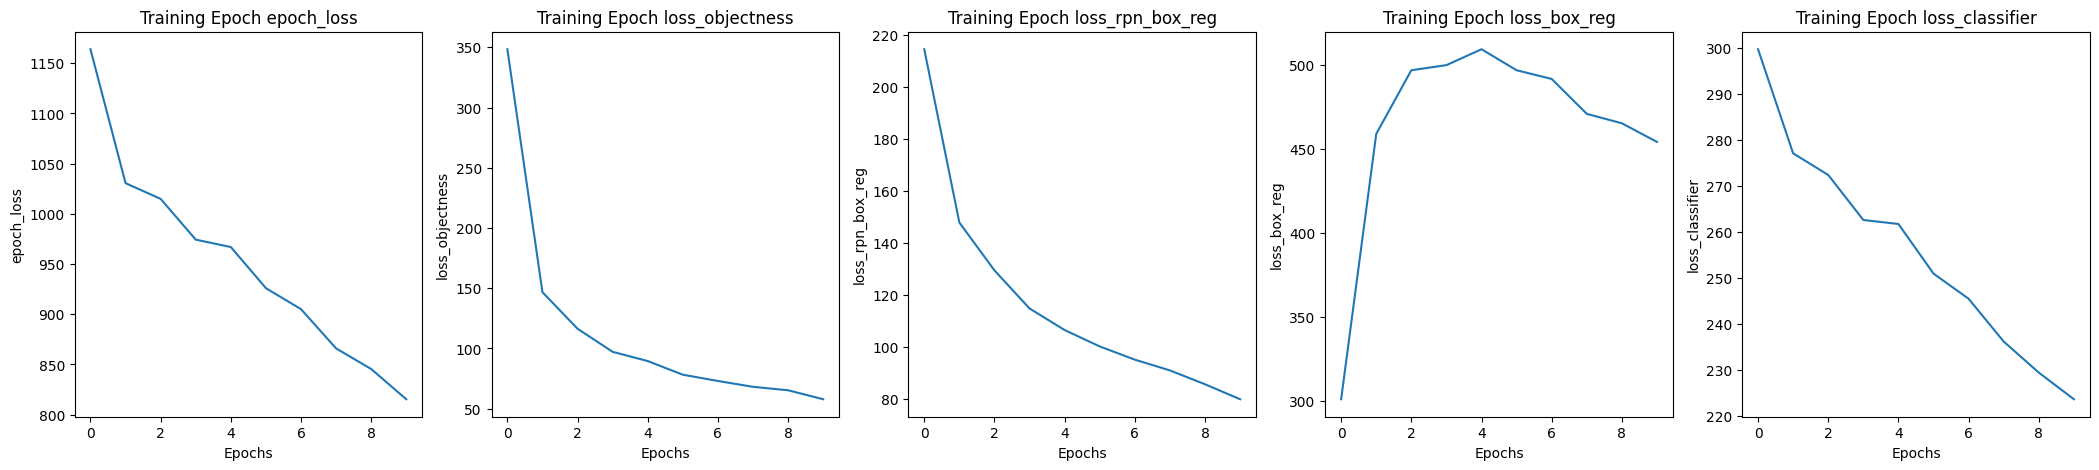

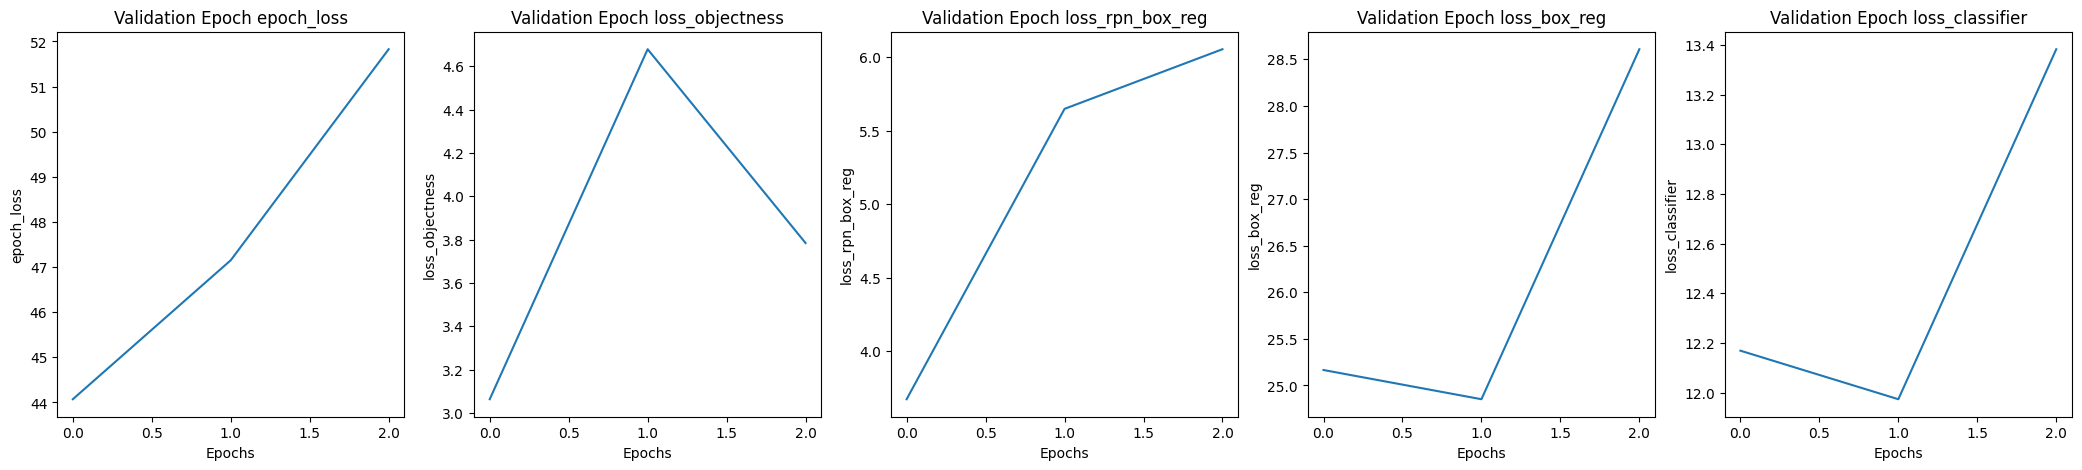

In [12]:
# Plot Baseline training and validation metrics
worker.plot_losses(True)
plt.show()
worker.plot_losses(False)
plt.show()

#### Section 4.1.4 - Baseline Testing

In [13]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=test_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
threshold = 0.1
# performance, maP = worker.model_test(test_dataloader, threshold)
performance = worker.model_test(test_dataloader, threshold)

In [15]:
# Plot Mean Average Precision
maP.compute()
maP.plot()

NameError: name 'maP' is not defined

In [16]:
performance = worker.get_test_metrics(performance, 0.5)

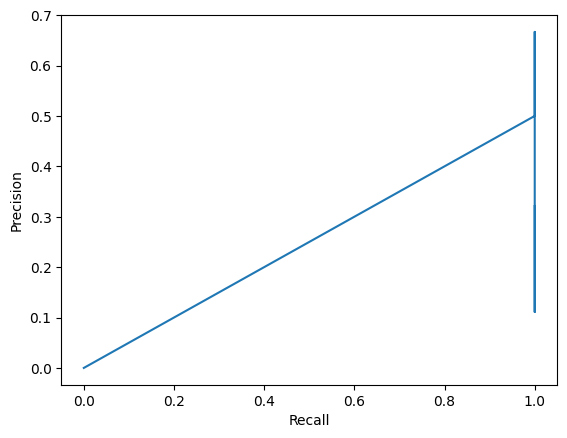

In [20]:
worker.plot_PR_curve(performance)

plt.show()

In [ ]:
plt.imshow(performance["Image"][0][0][0])
plt.show()